In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy.signal import periodogram
from scipy.stats.mstats import normaltest
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
import keras
from warnings import simplefilter
simplefilter("ignore")
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=16, titlepad=10)
plot_params = dict(color="0.75", style=".-", markeredgecolor="0.25", markerfacecolor="0.25", legend=False)
%config InlineBackend.figure_format = 'retina'

In [2]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(x=freq, y=y, hue=period, data=X, ci=False, ax=ax, palette=palette, legend=False)
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(name, xy=(1, y_), xytext=(6, 0), color=line.get_color(), xycoords=ax.get_yaxis_transform(), 
                    textcoords="offset points", size=14, va="center")
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(ts, fs=fs, detrend=detrend, window="boxcar", scaling='spectrum')
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(["Annual (1)", "Semiannual (2)", "Quarterly (4)", "Bimonthly (6)", "Monthly (12)", 
                        "Biweekly (26)", "Weekly (52)", "Semiweekly (104)"], rotation=30)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(alpha=0.75, s=3)
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_, y=y_, scatter_kws=scatter_kws, line_kws=line_kws, lowess=True, ax=ax, **kwargs)
    at = AnchoredText(f"{corr:.2f}", prop=dict(size="large"), frameon=True, loc="upper left")
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

# define train test split function
def train_test_datasets(df, x_len=12, y_len=1, test_loops=12):
    D = df.values
    rows, periods = D.shape
    
    # Training set creation
    loops = periods + 1 - x_len - y_len
    train = []
    for col in range(loops):
        train.append(D[:, col:col+x_len+y_len])
    train = np.vstack(train)
    X_train, y_train = np.split(train, [-y_len], axis=1)

    # Test set creation
    if test_loops > 0:
        X_train, X_test = np.split(X_train, [-rows*test_loops], axis=0)
        y_train, y_test = np.split(y_train, [-rows*test_loops], axis=0)
    else: # No test set: X_test is used to generate the future forecast
        X_test = D[:, -x_len:]     
        y_test = np.full((X_test.shape[0], y_len), np.nan) #Dummy value
    
    # Formatting required for scikit-learn
    if y_len == 1: 
        y_train = y_train.ravel()
        y_test = y_test.ravel()  
        
    return X_train, y_train, X_test, y_test

# define score metric function
def kpi(y_train, y_train_pred, y_test, y_test_pred, name=''):
    df = pd.DataFrame(columns = ['MAE','RMSE', 'Bias', 'MAE_pct', 'RMSE_pct', 'r2_score'], index=['Train','Test'])
    df.index.name = name
    df.loc['Train','MAE_pct'] = 100*np.mean(abs(y_train - y_train_pred))/np.mean(y_train)
    df.loc['Train','RMSE_pct'] = 100*np.sqrt(np.mean((y_train - y_train_pred)**2))/np.mean(y_train)
    df.loc['Train','Bias'] = 100*np.mean((y_train - y_train_pred))/np.mean(y_train)
    df.loc['Train','r2_score'] =  r2_score(y_train, y_train_pred)
    df.loc['Train','MAE'] = mean_absolute_error(y_train, y_train_pred)
    df.loc['Train','RMSE'] = mean_squared_error(y_train, y_train_pred, squared=False)
    df.loc['Test','MAE_pct'] = 100*np.mean(abs(y_test - y_test_pred))/np.mean(y_test) 
    df.loc['Test','RMSE_pct'] = 100*np.sqrt(np.mean((y_test - y_test_pred)**2))/np.mean(y_test)
    df.loc['Test','Bias'] = 100*np.mean((y_test - y_test_pred))/np.mean(y_test)
    df.loc['Test','r2_score'] =  r2_score(y_test, y_test_pred)
    df.loc['Test','MAE'] = mean_absolute_error(y_test, y_test_pred)
    df.loc['Test','RMSE'] = mean_squared_error(y_test, y_test_pred, squared=False)
    df = df.astype(float).round(2) #Round number for display
    print(df)

In [3]:
df = pd.read_csv('../input/milk-production/monthly_milk_production.csv')
df.head()

,Date,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


In [4]:
df.Date = pd.to_datetime(df.Date)

In [5]:
index = pd.date_range(start=df.Date.min(), end='1976-01', freq='M')
index

DatetimeIndex(['1962-01-31', '1962-02-28', '1962-03-31', '1962-04-30',
               '1962-05-31', '1962-06-30', '1962-07-31', '1962-08-31',
               '1962-09-30', '1962-10-31',
               ...
               '1975-03-31', '1975-04-30', '1975-05-31', '1975-06-30',
               '1975-07-31', '1975-08-31', '1975-09-30', '1975-10-31',
               '1975-11-30', '1975-12-31'],
              dtype='datetime64[ns]', length=168, freq='M')

In [6]:
df.shape

(168, 2)

In [7]:
df.set_index(index, inplace=True)

In [8]:
df.head()

,Date,Production
1962-01-31,1962-01-01,589
1962-02-28,1962-02-01,561
1962-03-31,1962-03-01,640
1962-04-30,1962-04-01,656
1962-05-31,1962-05-01,727


In [9]:
df.drop('Date', axis=1, inplace=True)
df.head()

,Production
1962-01-31,589
1962-02-28,561
1962-03-31,640
1962-04-30,656
1962-05-31,727


In [10]:
df.isnull().sum() # check if there is missing values in data

Production    0
dtype: int64

In [11]:
ss_decomposition = seasonal_decompose(df)
estimated_obs = ss_decomposition.observed # additive series
estimated_trend = ss_decomposition.trend # upword trend
estimated_seasonal = ss_decomposition.seasonal # annual seaonality
estimated_residual = ss_decomposition.resid

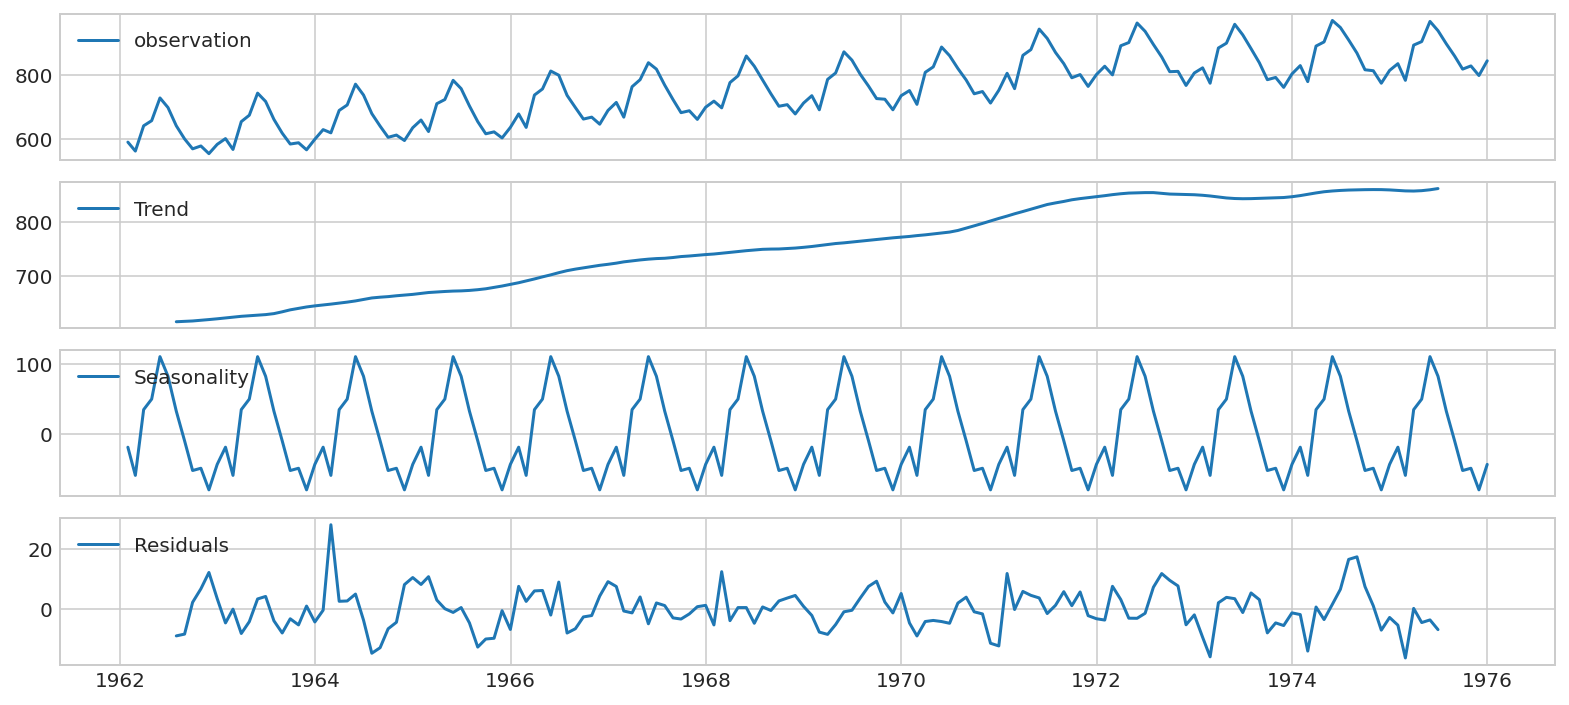

In [12]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)

axes[0].plot(estimated_obs, label='observation')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');

In [13]:
check = normaltest(df) # nonstationary
check

NormaltestResult(statistic=masked_array(data=[10.28850715539463],
             mask=[False],
       fill_value=1e+20), pvalue=array([0.00583283]))

In [14]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(df)

print("ADF: ", adf)
print("p-value:", pvalue) # nonstationary

ADF:  -1.3038115874221246
p-value: 0.627426708603034


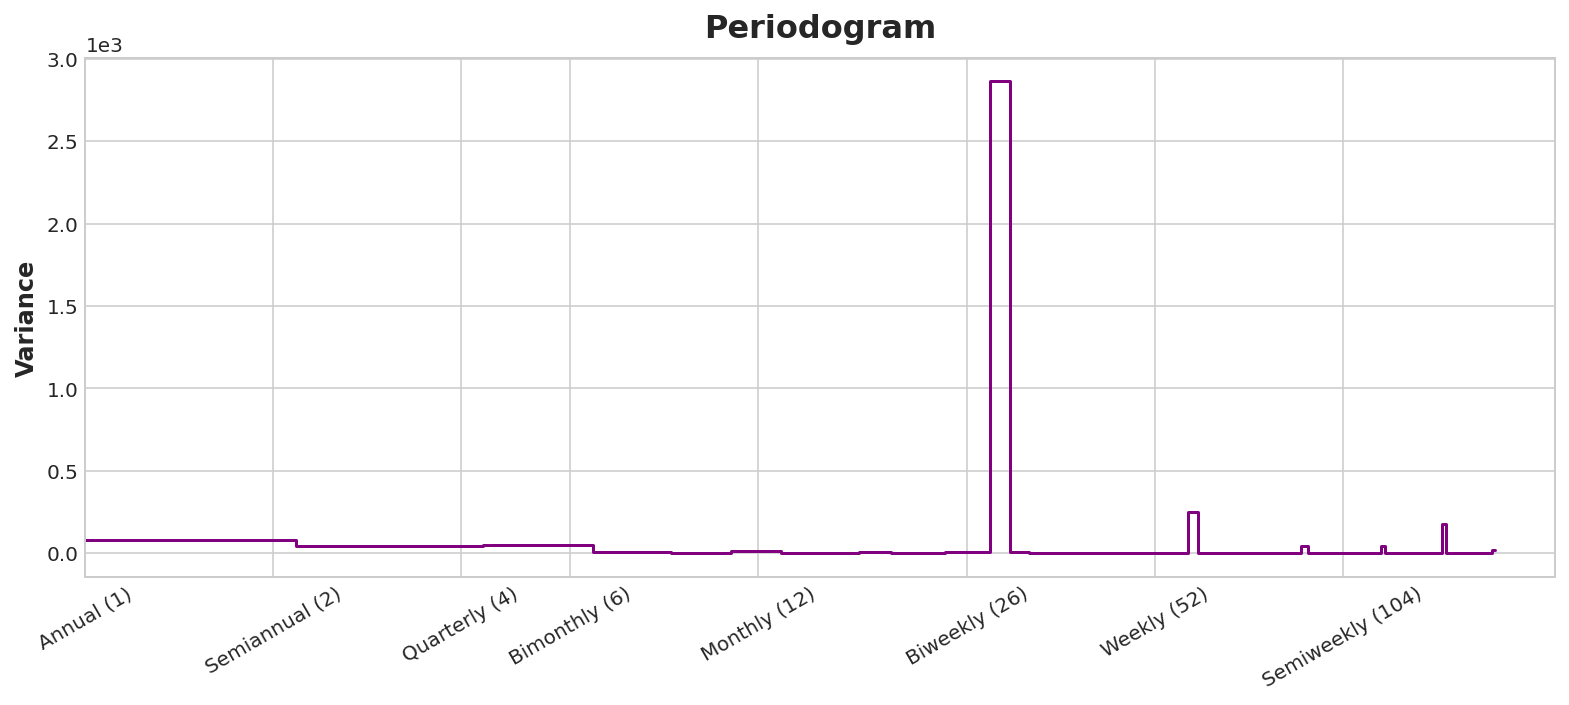

In [15]:
plot_periodogram(df['Production']); # strong biwekely seasonality

In [16]:
df.set_index(pd.PeriodIndex(df.index, freq="M"), inplace=True)

df.head()

,Production
1962-01,589
1962-02,561
1962-03,640
1962-04,656
1962-05,727


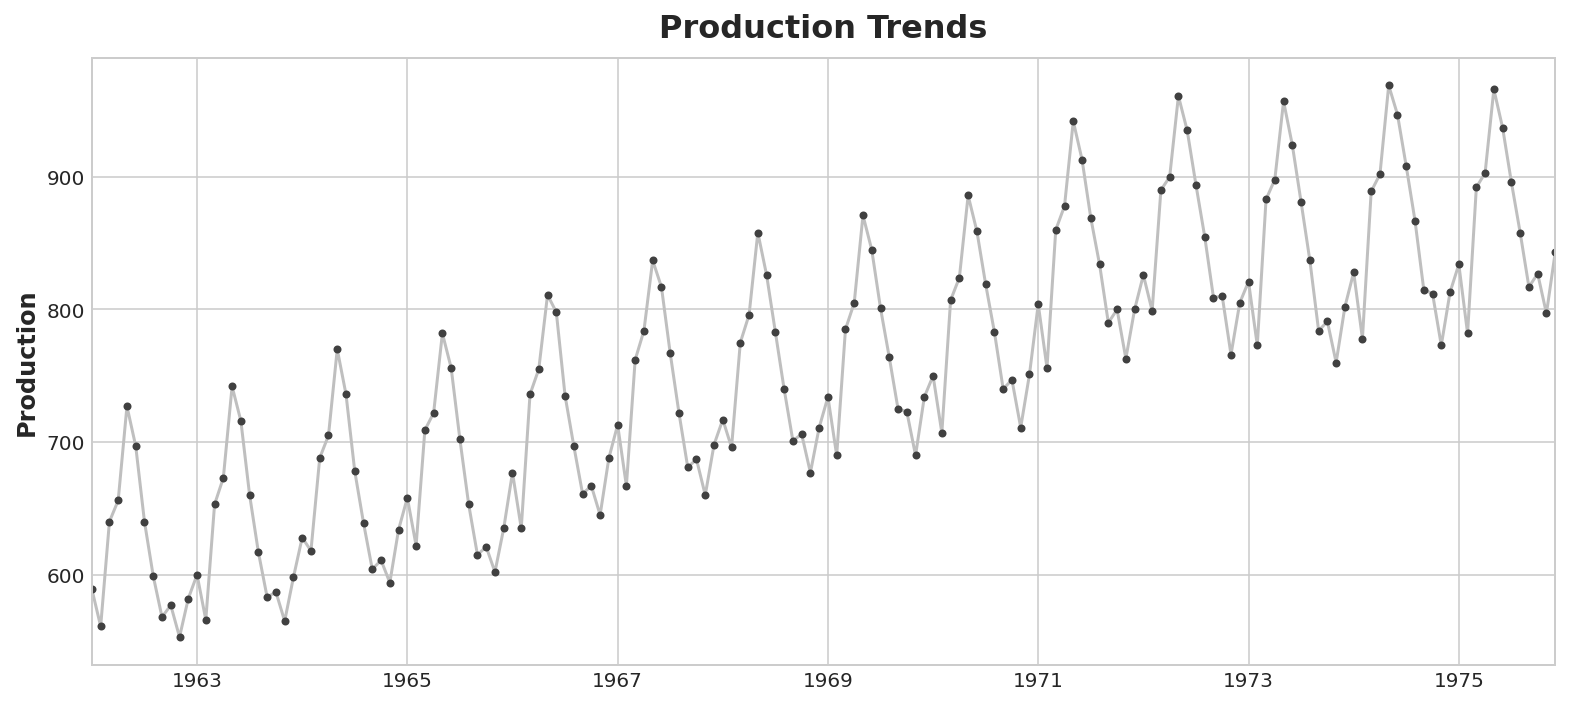

In [17]:
ax = df.Production.plot(title='Production Trends', **plot_params)
_ = ax.set(ylabel="Production")

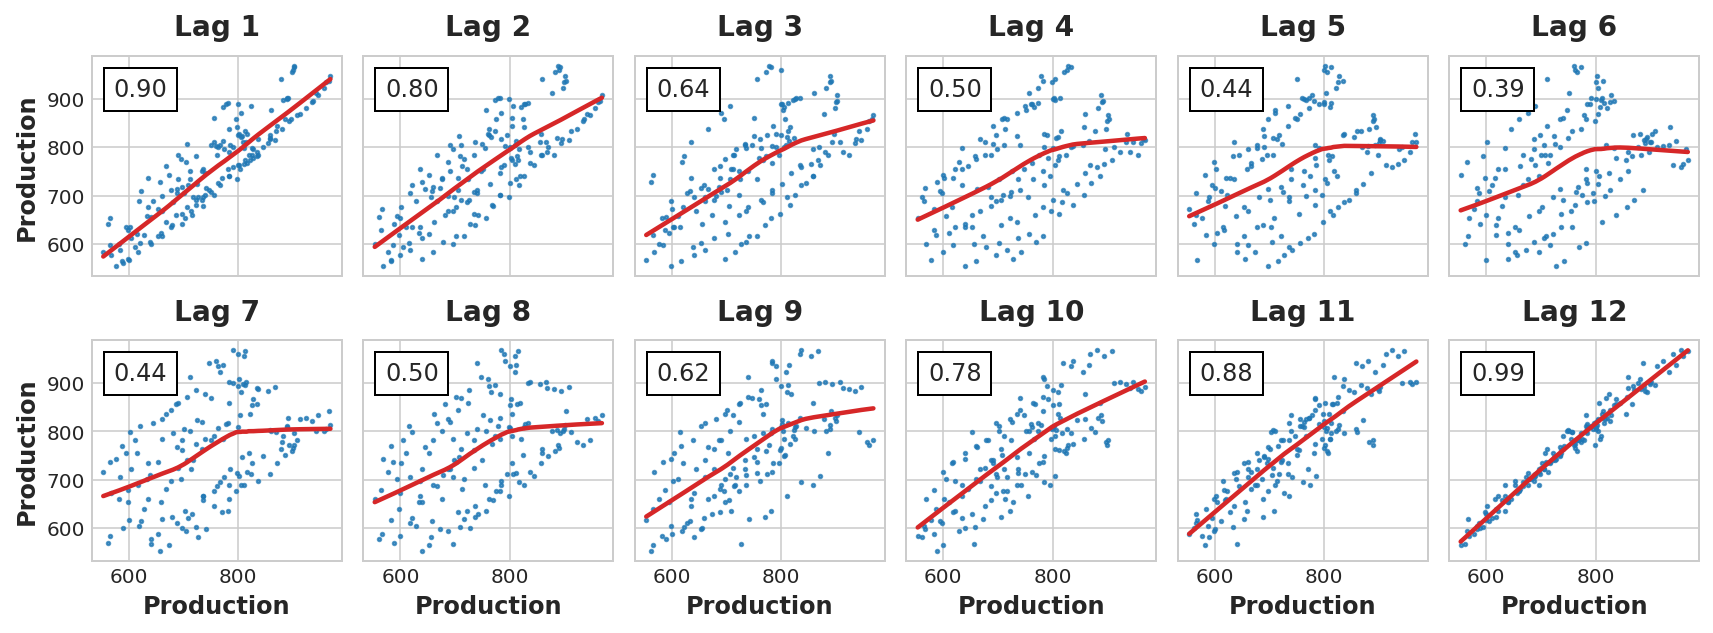

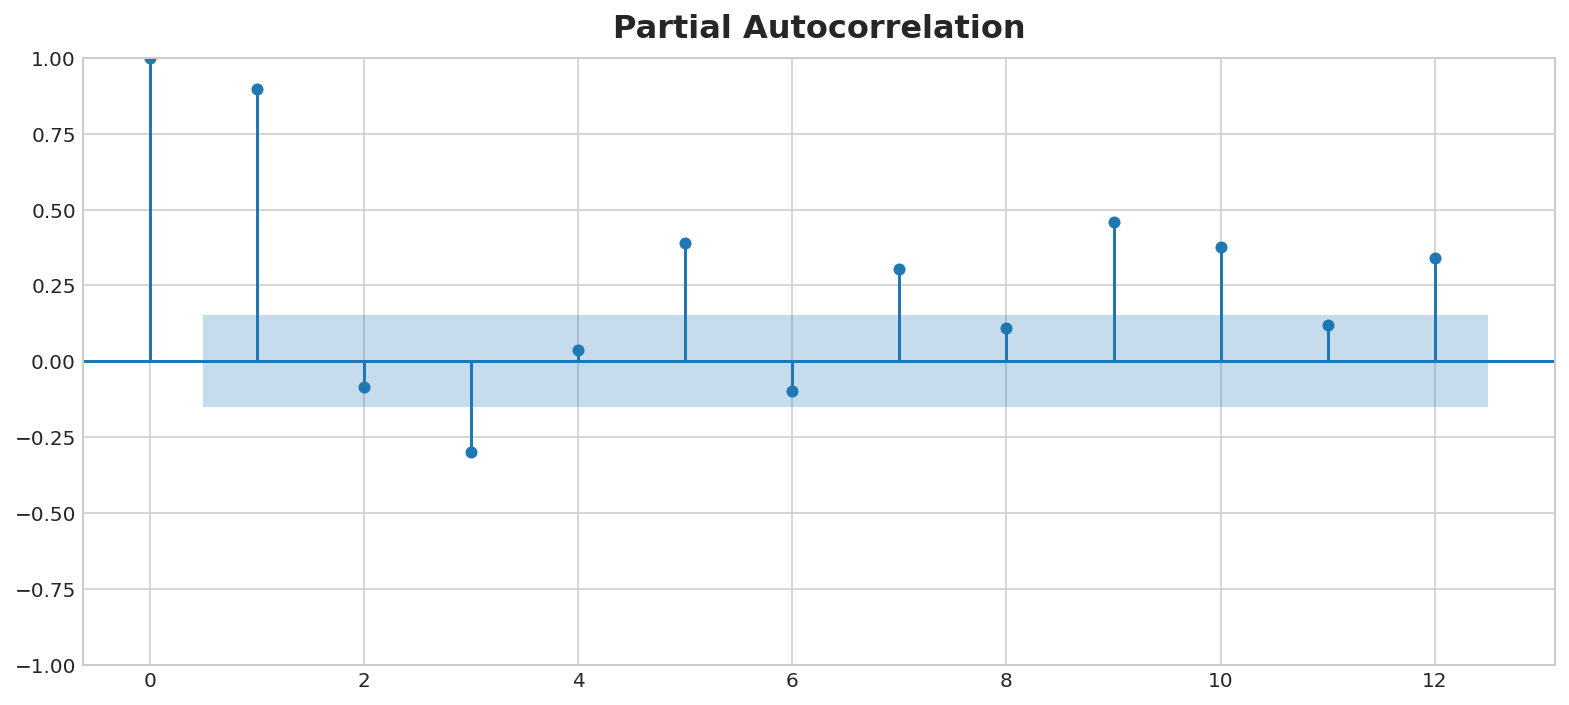

In [18]:
_ = plot_lags(df.Production, lags=12, nrows=2)
_ = plot_pacf(df.Production, lags=12) # strong lag 12

In [19]:
df = df.T # data transpose to prepare data split
df.head()

,1962-01,1962-02,1962-03,1962-04,1962-05,1962-06,1962-07,1962-08,1962-09,1962-10,...,1975-03,1975-04,1975-05,1975-06,1975-07,1975-08,1975-09,1975-10,1975-11,1975-12
Production,589,561,640,656,727,697,640,599,568,577,...,892,903,966,937,896,858,817,827,797,843


In [20]:
# Linear Regression as first model to compare

X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=12, y_len=1, test_loops=12)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

reg = LinearRegression() # Create a linear regression object
reg = reg.fit(X_train, y_train) # Fit it to the training data
# Create two predictions for the training and test sets
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)
kpi(y_train, y_train_pred, y_test, y_test_pred, name='Regression')

              MAE   RMSE  Bias  MAE_pct  RMSE_pct  r2_score
Regression                                                 
Train       10.91  14.83  0.00     1.44      1.96      0.98
Test        14.17  17.18 -1.13     1.64      1.99      0.90


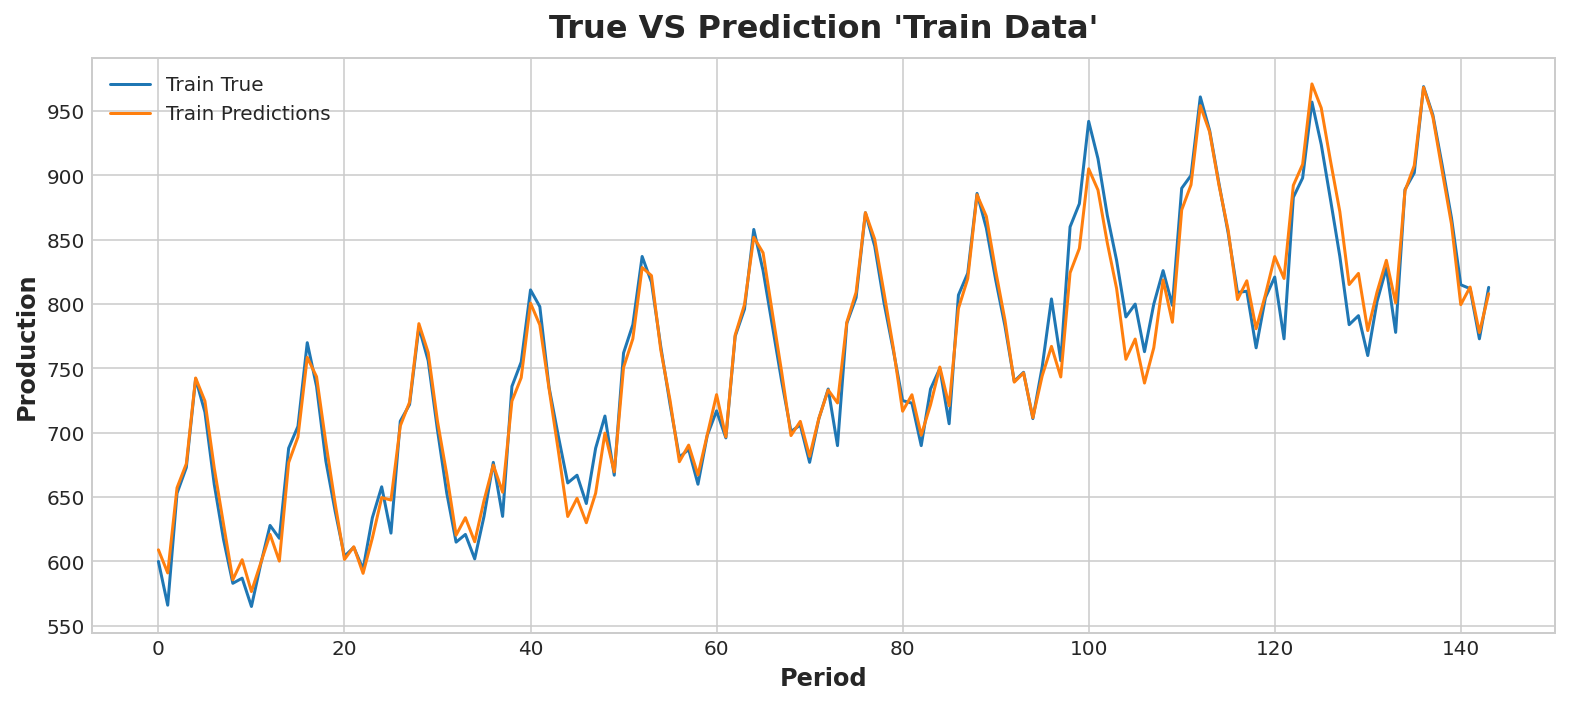

In [21]:
plt.plot(y_train, label='Train True')
plt.plot(y_train_pred, label='Train Predictions')
plt.title("True VS Prediction 'Train Data'") 
plt.xlabel("Period") 
plt.ylabel("Production")
plt.legend();

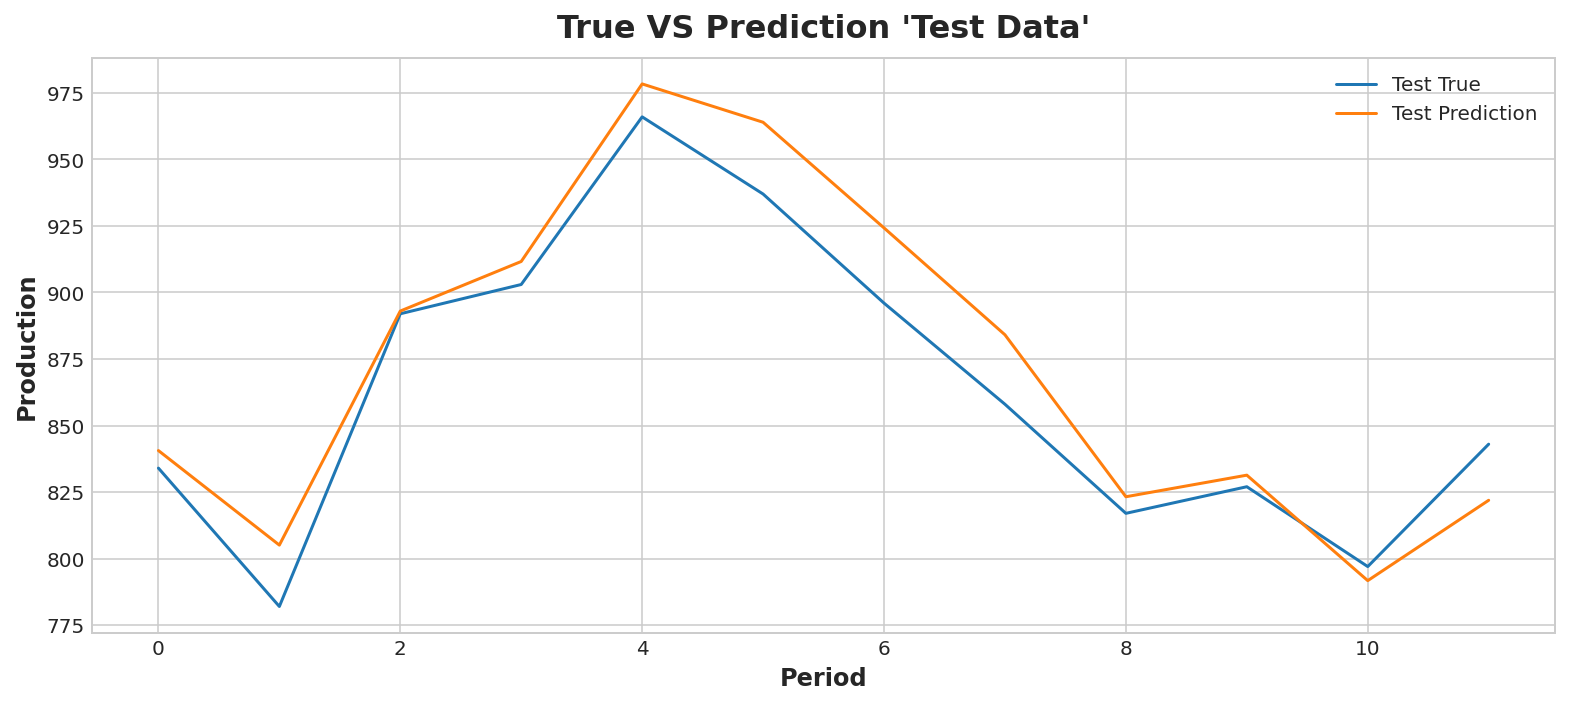

In [22]:
plt.plot(y_test, label='Test True')
plt.plot(y_test_pred, label='Test Prediction')
plt.title("True VS Prediction 'Test Data'") 
plt.xlabel("Period") 
plt.ylabel("Production")
plt.legend();

In [23]:
# prediction

X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=12, y_len=1, test_loops=0)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

reg = LinearRegression() # Create a linear regression object
reg = reg.fit(X_train,y_train) # Fit it to the training data
reg_forecast = pd.DataFrame(data=reg.predict(X_test), index=df.index, columns=['Next_Month'])
reg_forecast

,Next_Month
Production,848.5295


In [24]:
# use Random Forest with default parameters

X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=12, y_len=1, test_loops=12)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

forest = RandomForestRegressor()
forest.fit(X_train, y_train)

y_train_pred = forest.predict(X_train) 
y_test_pred = forest.predict(X_test) 
kpi(y_train, y_train_pred, y_test, y_test_pred, name='Forest')

          MAE   RMSE  Bias  MAE_pct  RMSE_pct  r2_score
Forest                                                 
Train    5.01   6.77  0.03     0.66      0.89      0.99
Test    12.40  16.91  0.31     1.44      1.96      0.90


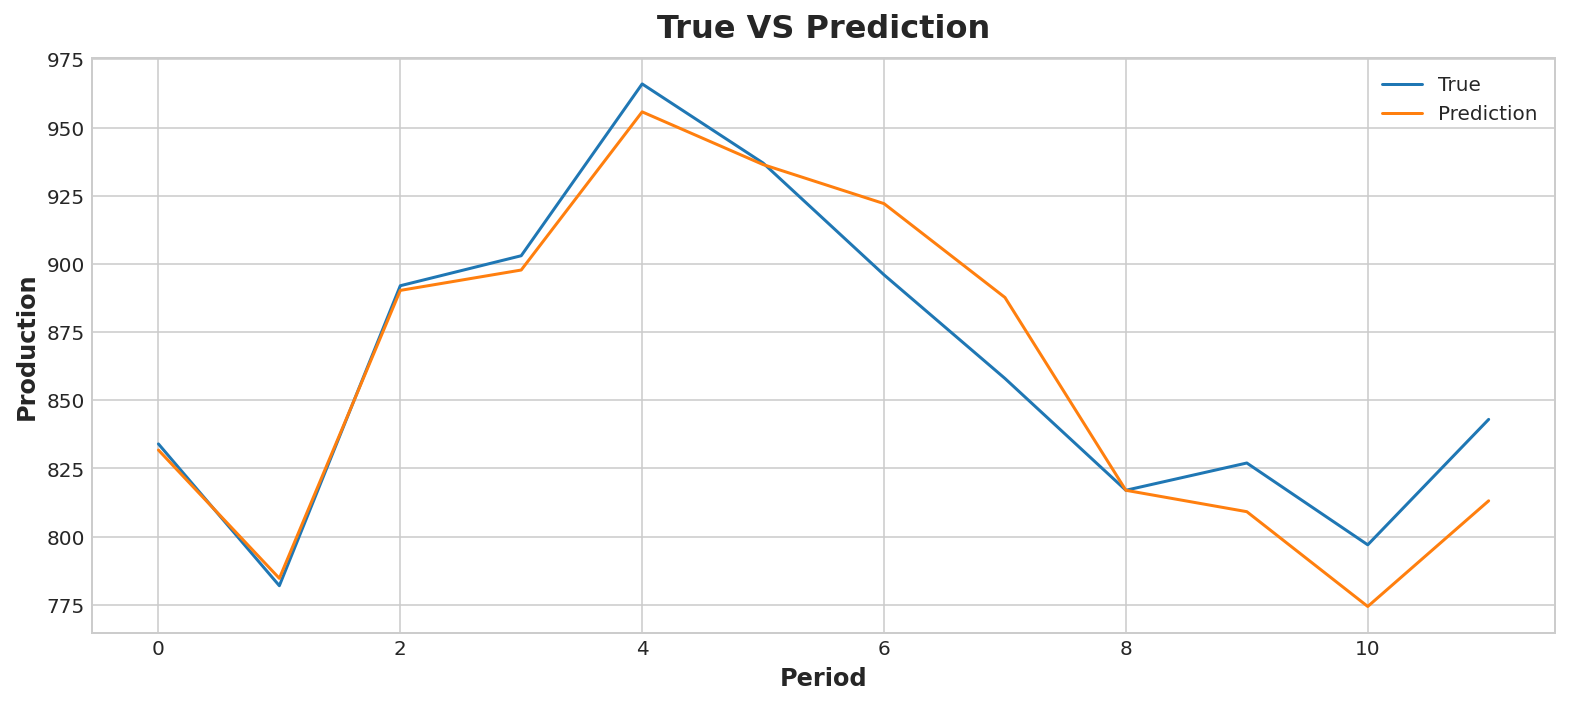

In [25]:
plt.plot(y_test, label='True')
plt.plot(y_test_pred, label='Prediction')
plt.title("True VS Prediction") 
plt.xlabel("Period") 
plt.ylabel("Production")
plt.legend();

In [26]:
# prediction

X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=12, y_len=1, test_loops=0)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

forest.fit(X_train, y_train) # Fit it to the training data
forecast = pd.DataFrame(data=forest.predict(X_test), index=df.index)
forecast

,0
Production,837.39


In [27]:
X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=12, y_len=1, test_loops=12)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

max_depth = list(range(1,11)) + [None]
min_samples_split = range(2,20)
min_samples_leaf = range(1,15)
max_features = range(2,11)
bootstrap = [True] #We force bootstrap
max_samples = [.7,.8,.9,.95,1]

param_dist = {'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'max_features': max_features,
              'bootstrap': bootstrap,
              'max_samples': max_samples}

forest1 = RandomForestRegressor(n_jobs=1)
forest_cv = RandomizedSearchCV(forest1, param_dist, cv=6, n_jobs=-1, verbose=1, n_iter=400, scoring='neg_mean_absolute_error')
forest_cv.fit(X_train, y_train)

print('Tuned Forest Parameters:', forest_cv.best_params_)

Fitting 6 folds for each of 400 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.0min


Tuned Forest Parameters: {'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.8, 'max_features': 8, 'max_depth': 5, 'bootstrap': True}


[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:  2.7min finished


In [28]:
X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=12, y_len=1, test_loops=12)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

max_depth = list(range(4, 9)) + [None]
min_samples_split = range(2, 7)
min_samples_leaf = range(1, 5)
max_features = range(8, 13)
bootstrap = [True] #We force bootstrap
max_samples = [0.8, 0.85, 0.9, 0.95, 1]

param_dist_f = {'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'max_features': max_features,
              'bootstrap': bootstrap,
              'max_samples': max_samples}

forest_f = RandomForestRegressor(n_jobs=1)
forest_cv_f = RandomizedSearchCV(forest_f, param_dist_f, cv=6, n_jobs=-1, verbose=1, n_iter=400, scoring='neg_mean_absolute_error')
forest_cv_f.fit(X_train, y_train)

print('Tuned Forest Parameters:', forest_cv_f.best_params_)

Fitting 6 folds for each of 400 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   55.7s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.1min


Tuned Forest Parameters: {'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': 0.8, 'max_features': 10, 'max_depth': 7, 'bootstrap': True}


[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:  2.8min finished


In [29]:
X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=12, y_len=1, test_loops=12)

forest_final = RandomForestRegressor(min_samples_split=3, min_samples_leaf=1, 
                                     max_samples=0.9, max_features=9, max_depth=8, bootstrap=True)  
forest_final.fit(X_train, y_train)  
 
y_train_pred = forest_final.predict(X_train)
y_test_pred = forest_final.predict(X_test) 
kpi(y_train, y_train_pred, y_test, y_test_pred, name='forest_final')

                MAE   RMSE  Bias  MAE_pct  RMSE_pct  r2_score
forest_final                                                 
Train          5.71   7.54  0.05     0.75      1.00      0.99
Test          12.43  15.67  0.27     1.44      1.82      0.92


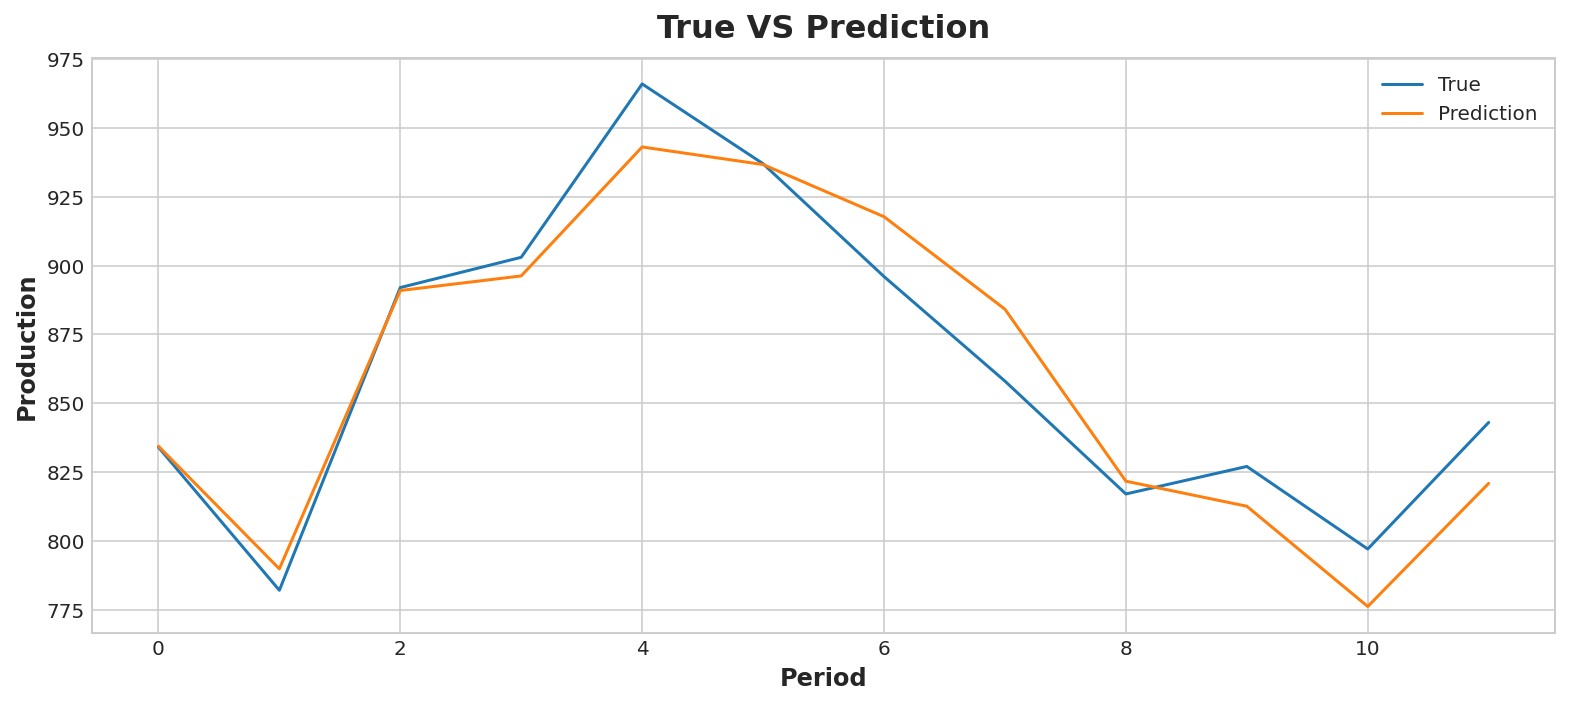

In [30]:
plt.plot(y_test, label='True')
plt.plot(y_test_pred, label='Prediction')
plt.title("True VS Prediction") 
plt.xlabel("Period") 
plt.ylabel("Production")
plt.legend();

In [31]:
# prediction

X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=12, y_len=1, test_loops=0)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

forest_final.fit(X_train, y_train) # Fit it to the training data
forecast = pd.DataFrame(data=forest_final.predict(X_test), index=df.index)
forecast

,0
Production,842.758402


In [32]:
# XGB model to predict one period

X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=12, y_len=1, test_loops=12)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

xgb = XGBRegressor() # predict 1 period

xgb.fit(X_train, y_train)  
 
y_train_pred = xgb.predict(X_train) 
y_test_pred = xgb.predict(X_test) 
kpi(y_train, y_train_pred, y_test, y_test_pred, name='xgb')

         MAE   RMSE  Bias  MAE_pct  RMSE_pct  r2_score
xgb                                                   
Train   0.00   0.01  0.00     0.00      0.00      1.00
Test   17.65  20.98  0.84     2.05      2.43      0.85


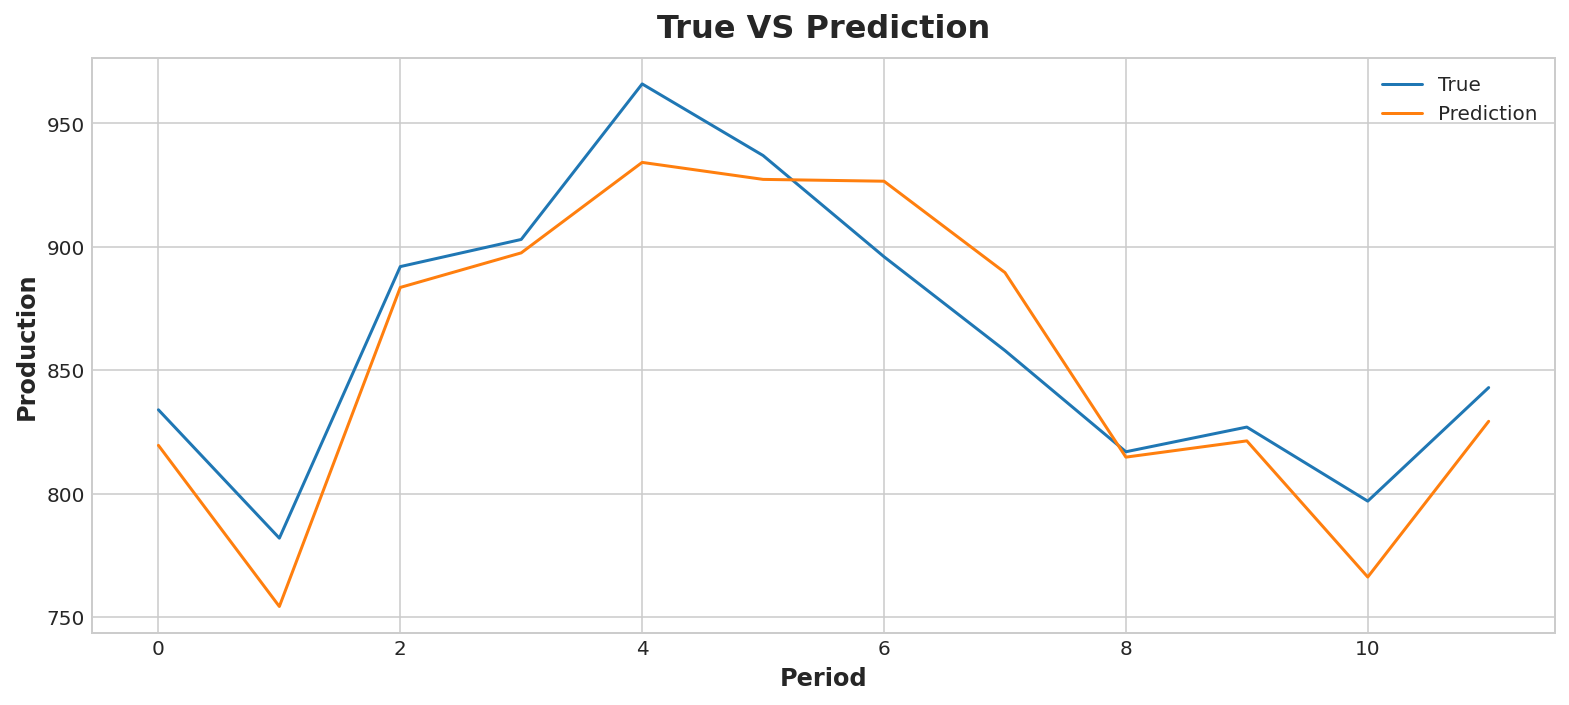

In [33]:
plt.plot(y_test, label='True')
plt.plot(y_test_pred, label='Prediction')
plt.title("True VS Prediction") 
plt.xlabel("Period") 
plt.ylabel("Production")
plt.legend();

In [34]:
# MultiRegressor using XGB model to predict more than one period

X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=12, y_len=2, test_loops=12)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

xgb = XGBRegressor() # predict 1 period
mul = MultiOutputRegressor(xgb, n_jobs=-1) # if predict more than 1 period

mul.fit(X_train, y_train)  
 
y_train_pred = mul.predict(X_train) 
y_test_pred = mul.predict(X_test) 
kpi(y_train, y_train_pred, y_test, y_test_pred, name='Multi')

         MAE   RMSE  Bias  MAE_pct  RMSE_pct  r2_score
Multi                                                 
Train   0.00   0.00 -0.00     0.00      0.00      1.00
Test   16.55  20.15  0.78     1.92      2.34      0.87


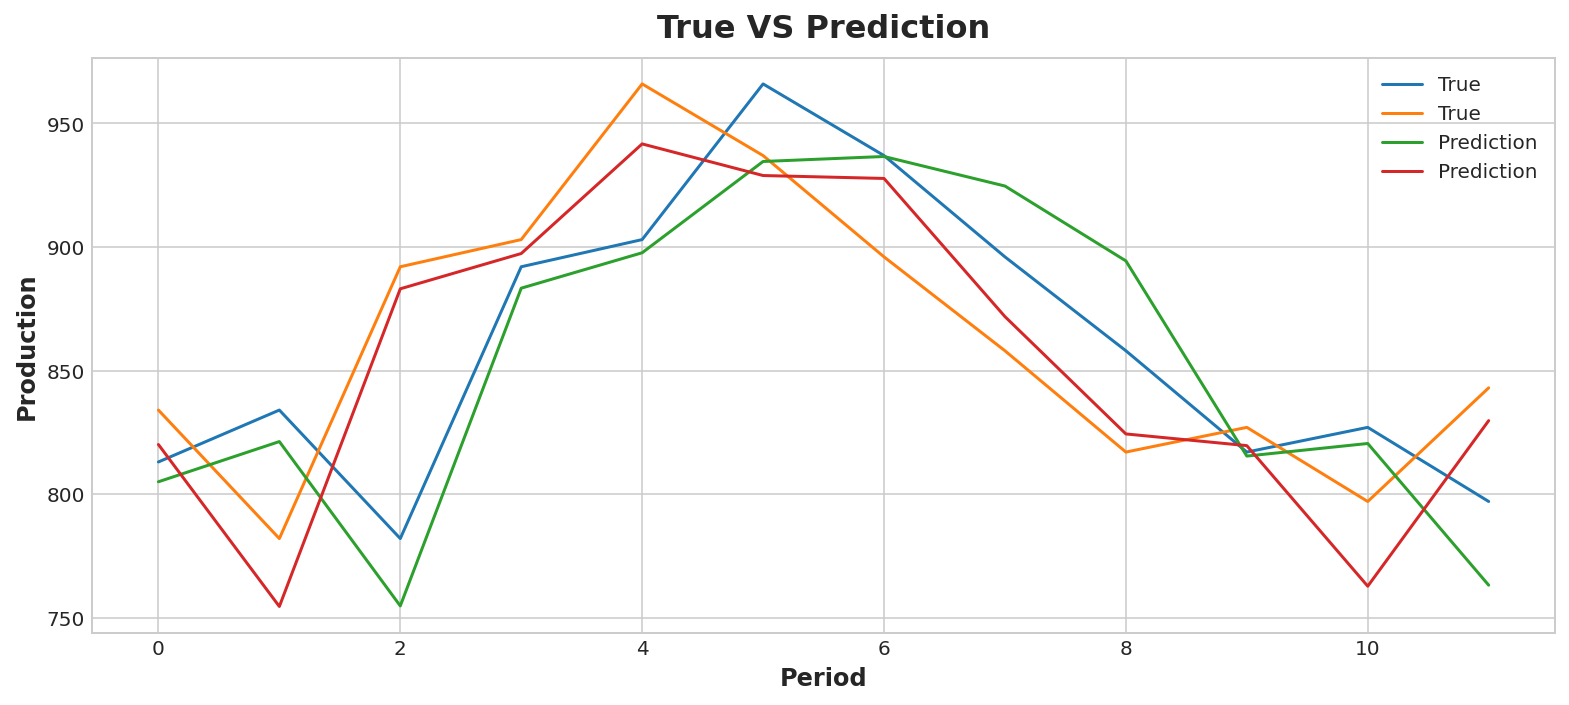

In [35]:
plt.plot(y_test, label='True')
plt.plot(y_test_pred, label='Prediction')
plt.title("True VS Prediction") 
plt.xlabel("Period") 
plt.ylabel("Production")
plt.legend();

In [36]:
# prediction

X_train, y_train, X_test, y_test = train_test_datasets(df, x_len=12, y_len=2, test_loops=0)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

mul.fit(X_train, y_train) # Fit it to the training data
forecast = pd.DataFrame(data=mul.predict(X_test), index=df.index)
forecast

,0,1
Production,832.989014,783.293884


## Deep Learning (LSTM) model

In [37]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [38]:
df = pd.read_csv('../input/milk-production/monthly_milk_production.csv')
df.Date = pd.to_datetime(df.Date)
df.set_index('Date', inplace=True)
df.tail()

,Production
Date,
1975-08-01,858
1975-09-01,817
1975-10-01,827
1975-11-01,797
1975-12-01,843


In [39]:
scaler = MinMaxScaler()
data = scaler.fit_transform(df)

# Split
cut = int(len(data) *0.9)

train, test = data[:cut,:], data[cut:,:]

In [40]:
n_steps = 3
n_features = 1

X_train, y_train = split_sequence(train, n_steps)
X_test, y_test = split_sequence(test, n_steps)

In [41]:
X_train.shape, X_test.shape

((148, 3, 1), (14, 3, 1))

In [42]:
# reshape from [samples, timesteps] into [samples, timesteps, features]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [43]:
X_train.shape, X_test.shape

((148, 3, 1), (14, 3, 1))

In [44]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=(n_steps, n_features)),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


model.compile(loss='mean_squared_error',optimizer='adam')

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=300 ,batch_size=4, verbose=0)

2022-02-11 20:45:58.059681: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-02-11 20:45:58.698582: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [45]:
y_train = scaler.inverse_transform(y_train)
y_train_pred = scaler.inverse_transform(model.predict(X_train))

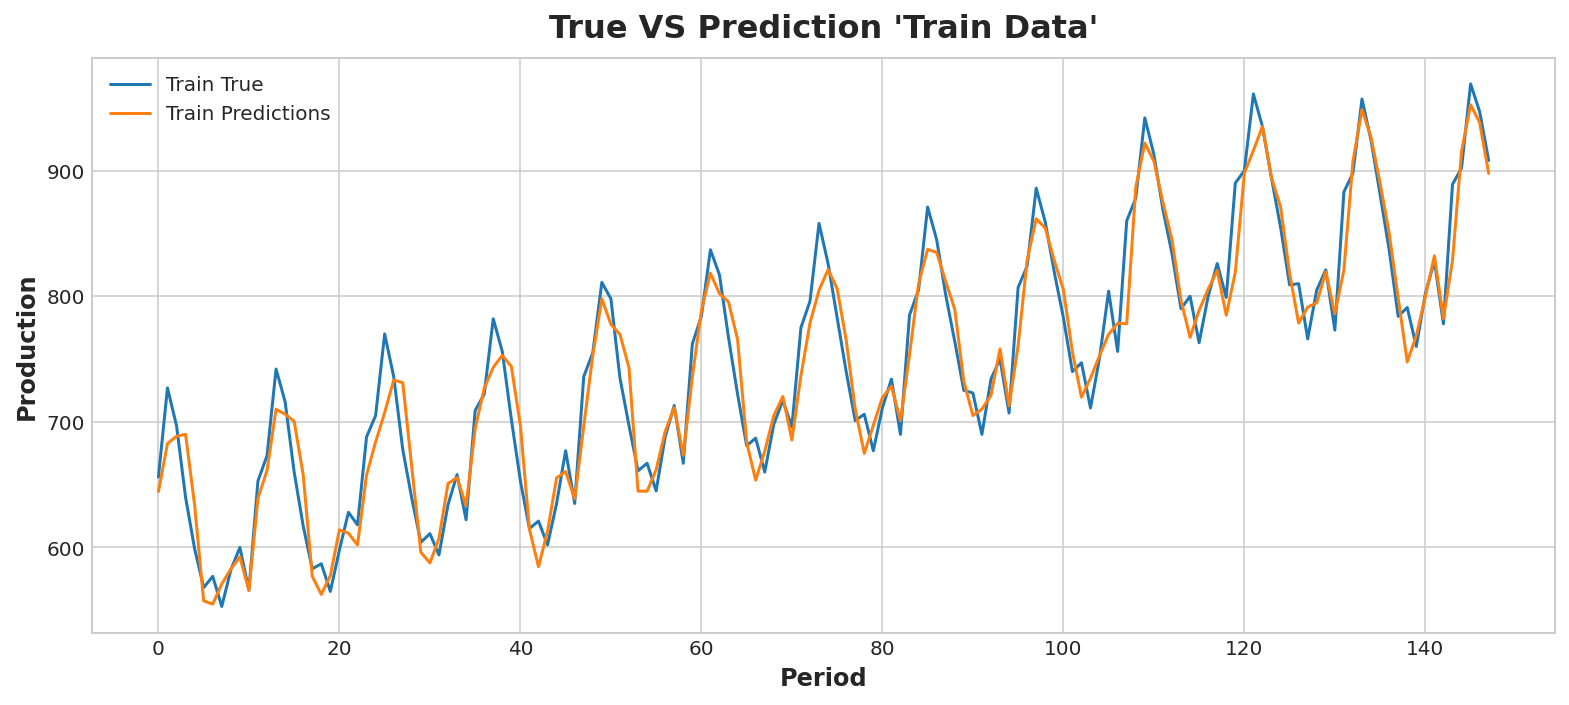

In [46]:
plt.plot(y_train, label='Train True')
plt.plot(y_train_pred, label='Train Predictions')
plt.title("True VS Prediction 'Train Data'") 
plt.xlabel("Period") 
plt.ylabel("Production")
plt.legend();

In [47]:
y_test = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(model.predict(X_test))

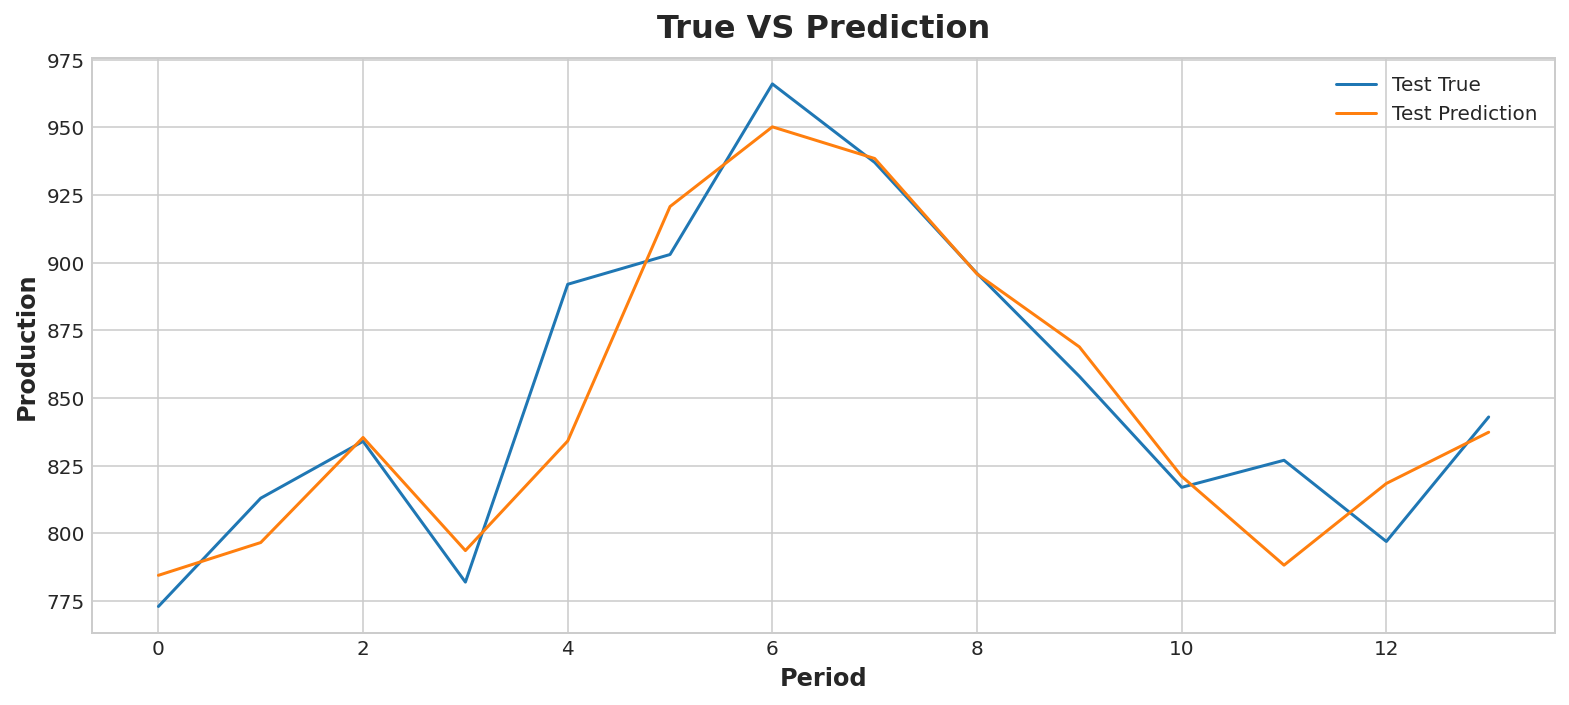

In [48]:
plt.plot(y_test, label='Test True')
plt.plot(y_test_pred, label='Test Prediction')
plt.title("True VS Prediction") 
plt.xlabel("Period") 
plt.ylabel("Production")
plt.legend();

In [49]:
kpi(y_train, y_train_pred, y_test, y_test_pred, name='LSTM')

         MAE   RMSE  Bias  MAE_pct  RMSE_pct  r2_score
LSTM                                                  
Train  18.92  24.73  0.44     2.53      3.31      0.94
Test   15.34  21.68  0.46     1.80      2.54      0.85


In [50]:
# demonstrate prediction
future_pred = data[-n_steps:]
x_input = future_pred
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
yhat = scaler.inverse_transform(yhat)
print('Prediction of Next Month Production is: ', round(float(yhat), 2))

Prediction of Next Month Production is:  870.25


In [51]:
forecast = pd.DataFrame(data=yhat, columns=['Next_Production'])
forecast

,Next_Production
0,870.246704


## Forecast more than one period LSTM

In [52]:
 # split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [53]:
df = pd.read_csv('../input/milk-production/monthly_milk_production.csv')
df.Date = pd.to_datetime(df.Date)
df.set_index('Date', inplace=True)
df.tail()

,Production
Date,
1975-08-01,858
1975-09-01,817
1975-10-01,827
1975-11-01,797
1975-12-01,843


In [54]:
data = np.array(df['Production'])

# Split
cut = int(len(data) *0.9)

train, test = data[:cut], data[cut:]

In [55]:
n_steps_in, n_steps_out = 3, 2
n_features = 1

X_train, y_train = split_sequence(train, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(test, n_steps_in, n_steps_out)

X_train.shape, X_test.shape

((147, 3), (13, 3))

In [56]:
# reshape from [samples, timesteps] into [samples, timesteps, features]

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

X_train.shape, X_test.shape

((147, 3, 1), (13, 3, 1))

In [57]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# define model
model1 = tf.keras.models.Sequential(
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=(n_steps_in, n_features)))
model1.add(tf.keras.layers.LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model1.add(tf.keras.layers.LSTM(100, activation='relu'))
model1.add(tf.keras.layers.Dense(n_steps_out))
#model1.add(tf.keras.layers.Lambda(lambda x: x * 400))
model1.compile(optimizer='adam', loss='mse')
# fit model
model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=300, batch_size=4, verbose=0)

In [58]:
y_train_pred = model1.predict(X_train)

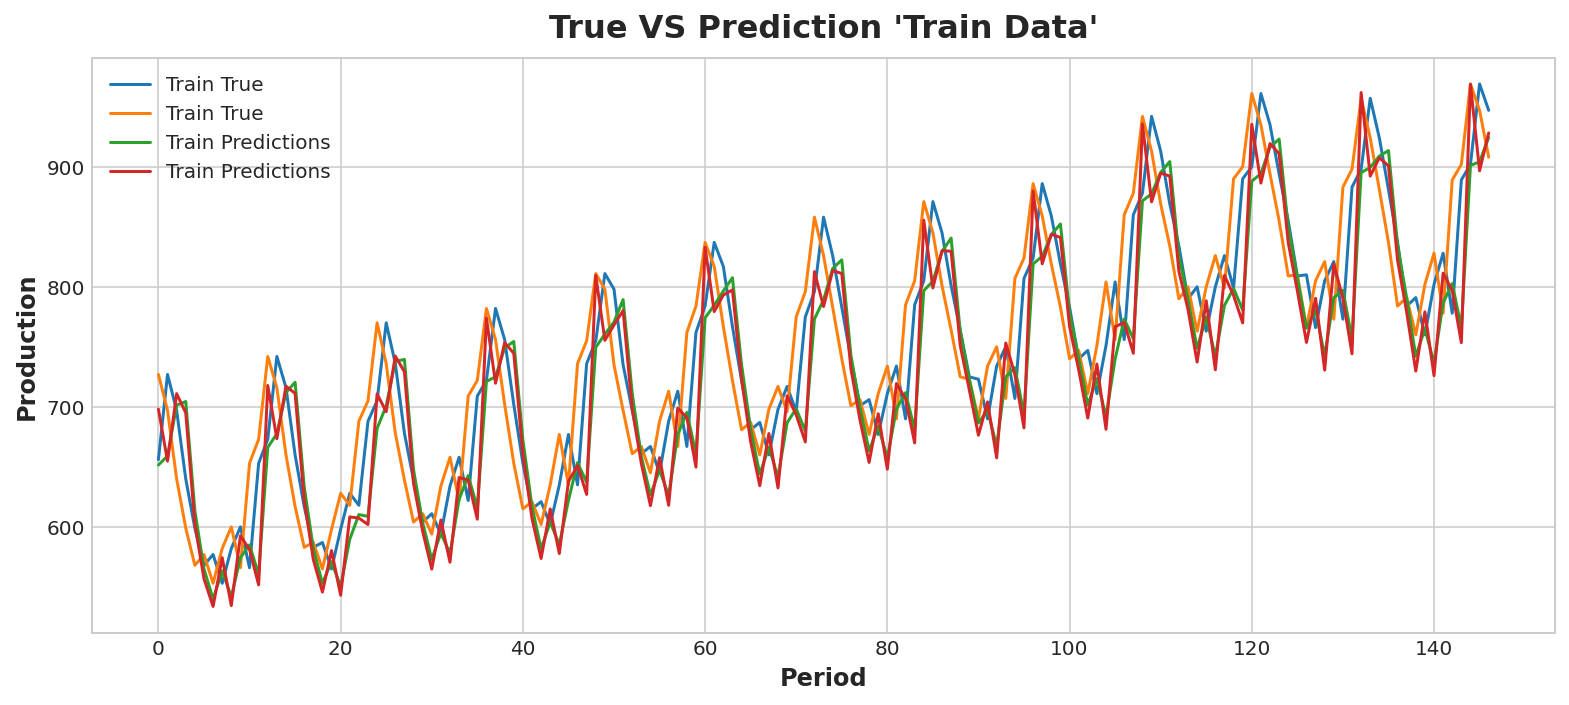

In [59]:
plt.plot(y_train, label='Train True')
plt.plot(y_train_pred, label='Train Predictions')
plt.title("True VS Prediction 'Train Data'") 
plt.xlabel("Period") 
plt.ylabel("Production")
plt.legend();

In [60]:
y_test_pred = model1.predict(X_test)

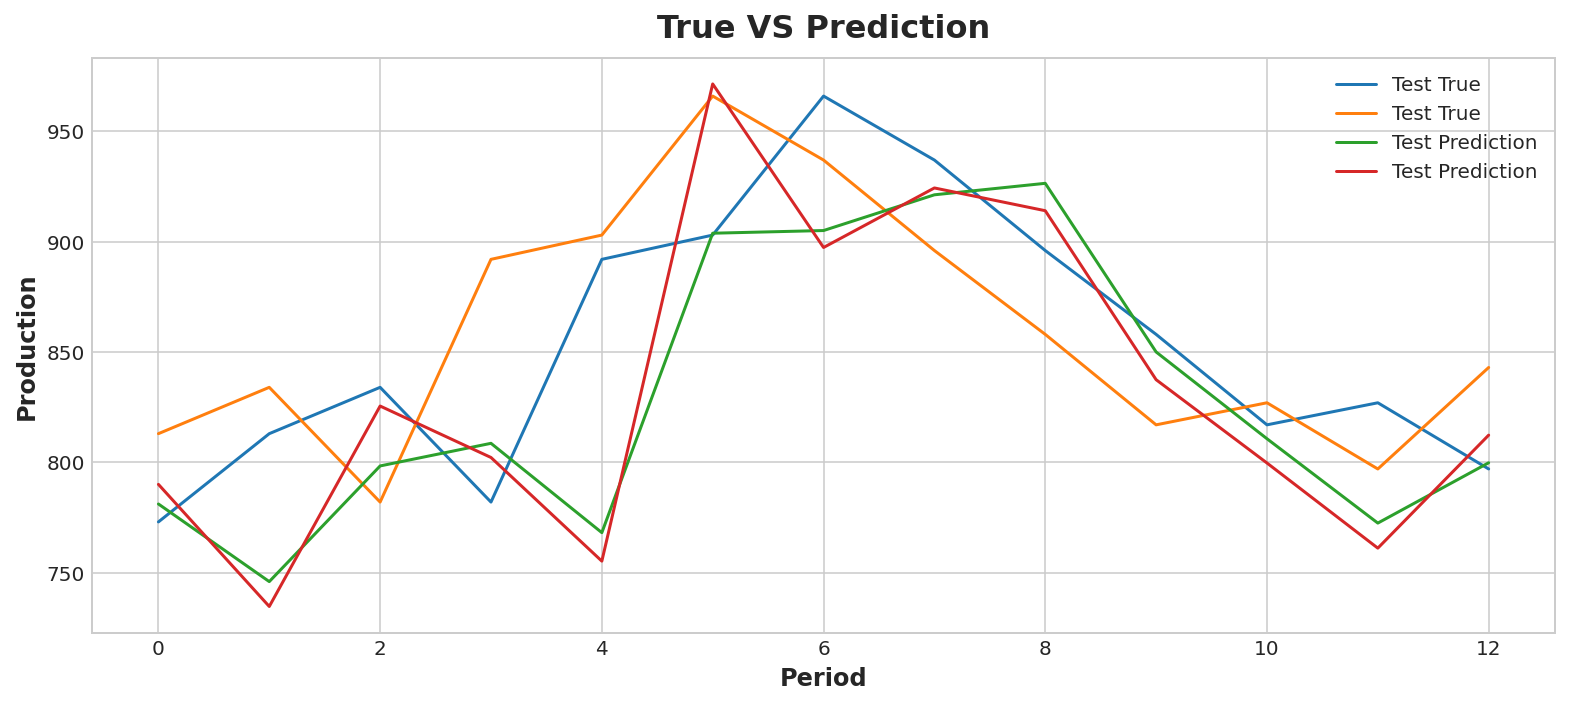

In [61]:
plt.plot(y_test, label='Test True')
plt.plot(y_test_pred, label='Test Prediction')
plt.title("True VS Prediction") 
plt.xlabel("Period") 
plt.ylabel("Production")
plt.legend();

In [62]:
mean_absolute_error(y_test, y_test_pred)

41.84983708308293

In [63]:
# demonstrate prediction
future_pred = data[-n_steps_in:]
x_input = future_pred
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model1.predict(x_input, verbose=0)
print('Prediction of Next two Months Production is: ', yhat)

Prediction of Next two Months Production is:  [[825.54315 850.83984]]
